In [1]:
import xarray as xr
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/utilities/"))
from plotting_utilities import *

basedir = '/work/bb1018/b380873/traj_output/'
clams_fi = xr.open_dataset( basedir + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc' )
icon_fi = xr.open_dataset( basedir + 'ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc' )

## Cloud mass mixing ratio differences

### (1) Plots the trajectory values versus a normalized or absolute time axis

In [5]:
# Define bins in normalized and absolute time
m = 100
tbins_norm = np.linspace( 0, 1, m )
tbins = np.linspace( 0, 7651, m )

# How many trajectories are we handling? (for now)
n = 1000
diff_vals = np.zeros( (n, m) )
diff_vals[:] = np.nan

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


(0, 1)

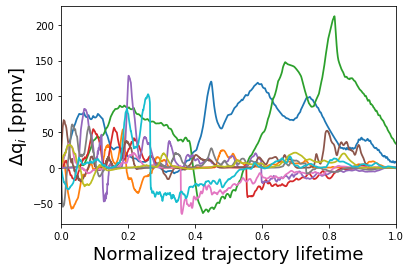

In [3]:
# Plot the differences along this 'time patch' versus a normalized time coordinate
fs = 18
fig = plt.figure()

for j in np.arange(10):
    #print(j)
    icon_traj0 = icon_fi['qi'][:,j]
    clams_traj0 = clams_fi['qi'][:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_traj0) > 0) )

    # Extract the qi values in this continuous 'time patch' for both CLaMS and ICON
    start = i[1][0]
    end = i[-1][0]

    # Calculate the qi differences along this 'time patch'
    clams_traj0 = clams_traj0[start:end]
    icon_traj0 = icon_traj0[start:end]
    diff = icon_traj0 - clams_traj0

    # Calculate a normalized time coordinate
    t_norm = np.arange(len(diff))/len(diff)
    
    plt.plot( t_norm, diff*10**6, lw=1.75 )
    
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.ylabel( r'$\Delta$q$_i$ [ppmv]', fontsize=fs )
plt.xlim([0,1])

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


(0, 51)

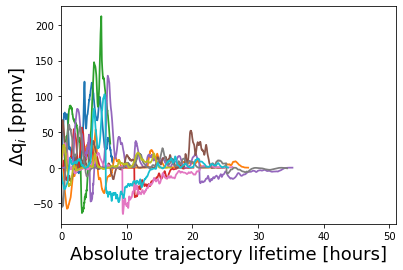

In [4]:
# Plot the differences along this 'time patch' versus an absolute time coordinate
fs = 18
fig = plt.figure()

for j in np.arange(10):
    #print(j)
    icon_traj0 = icon_fi['qi'][:,j]
    clams_traj0 = clams_fi['qi'][:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_traj0) > 0) )

    # Extract the qi values in this continuous 'time patch' for both CLaMS and ICON
    start = i[1][0]
    end = i[-1][0]

    # Calculate the qi differences along this 'time patch'
    clams_traj0 = clams_traj0[start:end]
    icon_traj0 = icon_traj0[start:end]
    diff = icon_traj0 - clams_traj0
    
    plt.plot( np.arange(len(diff))*24/3600., diff*10**6, lw=1.75 )
    
plt.xlabel( 'Absolute trajectory lifetime [hours]', fontsize=fs )
plt.ylabel( r'$\Delta$q$_i$ [ppmv]', fontsize=fs )
plt.xlim( [0, 51] )

### (2) Digitize the trajectory differences along the normalized or absolute time coordinate

In [15]:
%%time
# Digitize the differences along this 'time patch' versus a normalized time coordinate
icon_traj = icon_fi['qi']
clams_traj = clams_fi['qi']

for j in np.arange(n):
    if j%100 == 0:
        print(j)
        
    # Reinitialize this list of differences at every iteration with the bin number <m>
    diff_list = [ [] for i in np.arange(m) ]
    icon_qi = icon_traj[:,j]
    clams_qi = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_qi) > 0) )

    # Extract the qi values in this continuous 'time patch' for both CLaMS and ICON
    # only if such a patch exists
    if len(i) > 3:
        start = i[1][0]
        end = i[-1][0]
    
        # Calculate the qi differences along this 'time patch'
        clams_qi = clams_qi[start:end]
        icon_qi = icon_qi[start:end]
        diff = icon_qi - clams_qi

        # Calculate a normalized time coordinate
        t_norm = np.arange(len(diff))/len(diff)
    
        # Digitize these t_norm values into tbins
        #k = np.digitize( x=t_norm, bins=tbins )
        k = xr.apply_ufunc( np.digitize, t_norm, tbins_norm )
    
        for elem_idx, group_idx in enumerate(k):
            diff_list[group_idx].append( diff[elem_idx].values*10**6 )
    
        for l in np.arange(m):
            if len(diff_list[l]):
                diff_vals[j,l] = np.nanmean( diff_list[l] )
    else:
        continue

0


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


100
200
300
400
500
600
700
800
900
CPU times: user 11min 37s, sys: 3min 9s, total: 14min 47s
Wall time: 15min 9s


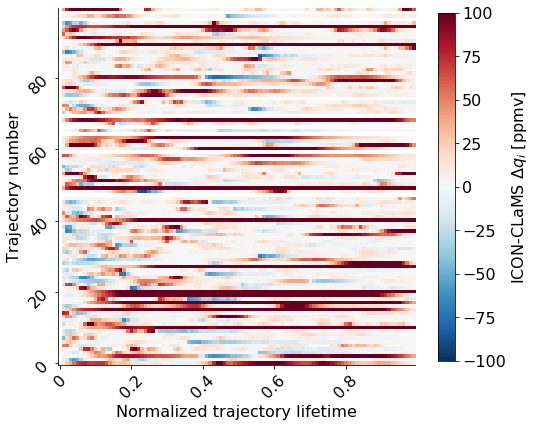

In [11]:
fs = 16
fig = plt.figure( figsize=(8,8) )
plt.imshow( diff_vals[:100], aspect=1, origin='lower', cmap=cm.RdBu_r, vmin=-100, vmax=100 )
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.ylabel( 'Trajectory number', fontsize=fs )
plt.gca().set_xticks( [0, 20, 40, 60, 80] )
plt.gca().set_xticklabels( [0, 0.2, 0.4, 0.6, 0.8] )
sexy_axes( plt.gca(), fs=fs )
cb = plt.colorbar( shrink=0.8 )
cb.set_label( r'ICON-CLaMS $\Delta q_i$ [ppmv]', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

In [6]:
%%time
# Digitize the differences along this 'time patch' versus an absolute time coordinate
icon_traj = icon_fi['qi']
clams_traj = clams_fi['qi']

for j in np.arange(n):
    if j%100 == 0:
        print(j)
        
    # Reinitialize this list of differences at every iteration with the bin number <m>
    diff_list = [ [] for i in np.arange(m) ]
    icon_qi = icon_traj[:,j]
    clams_qi = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_qi) > 0) )

    # Extract the qi values in this continuous 'time patch' for both CLaMS and ICON
    # only if such a patch exists
    if len(i) > 3:
        start = i[1][0]
        end = i[-1][0]
    
        # Calculate the qi differences along this 'time patch'
        clams_qi = clams_qi[start:end]
        icon_qi = icon_qi[start:end]
        diff = icon_qi - clams_qi

        # Calculate an absolute time coordinate
        t_abs = np.arange(len(diff))
    
        # Digitize these t_norm values into tbins
        #k = np.digitize( x=t_norm, bins=tbins )
        k = xr.apply_ufunc( np.digitize, t_abs, tbins )
    
        for elem_idx, group_idx in enumerate(k):
            diff_list[group_idx].append( diff[elem_idx].values*10**6 )
    
        for l in np.arange(m):
            if len(diff_list[l]):
                diff_vals[j,l] = np.nanmean( diff_list[l] )
    else:
        continue

0


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


100
200
300
400
500
600
700
800
900
CPU times: user 12min 38s, sys: 3min 31s, total: 16min 10s
Wall time: 16min 27s


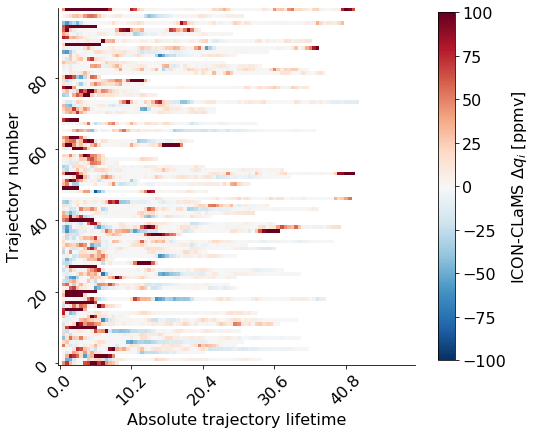

In [16]:
fs = 16
fig = plt.figure( figsize=(8,8) )
plt.imshow( diff_vals[:100], aspect=1, origin='lower', cmap=cm.RdBu_r, vmin=-100, vmax=100 )
plt.xlabel( 'Absolute trajectory lifetime', fontsize=fs )
plt.ylabel( 'Trajectory number', fontsize=fs )
plt.gca().set_xticks( [0, 20, 40, 60, 80] )
xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
plt.gca().set_xticklabels( xtic_vals )
sexy_axes( plt.gca(), fs=fs )
cb = plt.colorbar( shrink=0.8 )
cb.set_label( r'ICON-CLaMS $\Delta q_i$ [ppmv]', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

### (3) Bin these digitized values either in normalized or absolute time into a 2D histogram

In [15]:
# Count how many trajectories hit a certain qi difference along the normalized lifetime
qi_diff_bins = np.linspace( -100, 100, 50 )
diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins)[0], axis=0, arr=diff_vals ) #, weights=

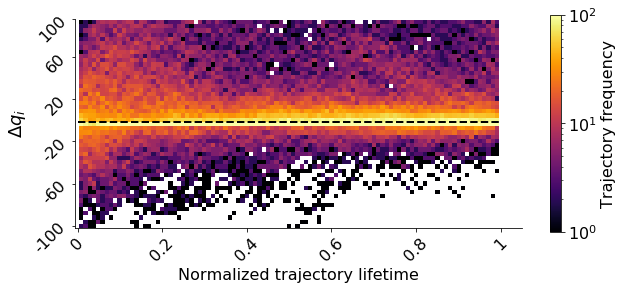

In [13]:
fs = 16
fig = plt.figure( figsize=(10,8) )
plt.imshow( diff_hist, aspect=1, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=100) )
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.plot( [0, 100], [24.5, 24.5], color='k', linestyle='--', lw=2 )

plt.ylabel( r'$\Delta q_i$', fontsize=fs+2 )
plt.gca().set_yticks( [0, 10, 20, 30, 40, 49] )
plt.gca().set_yticklabels( [-100, -60, -20, 20, 60, 100] )
plt.gca().set_xticks( [0, 20, 40, 60, 80, 100] )
plt.gca().set_xticklabels( [0, 0.2, 0.4, 0.6, 0.8, 1] )
sexy_axes( plt.gca(), fs=fs )
cb = plt.colorbar( shrink=0.5 )
cb.set_label( r'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

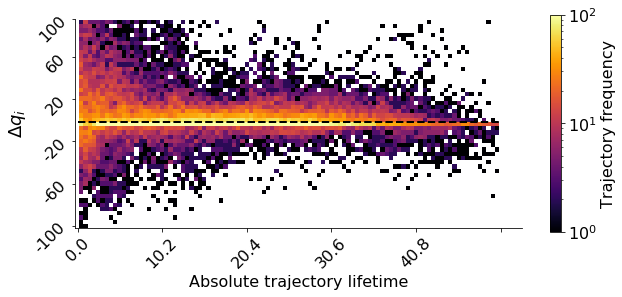

In [18]:
fs = 16
fig = plt.figure( figsize=(10,8) )
plt.imshow( diff_hist, aspect=1, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=100) )
plt.xlabel( 'Absolute trajectory lifetime', fontsize=fs )
plt.plot( [0, 100], [24.5, 24.5], color='k', linestyle='--', lw=2 )

plt.ylabel( r'$\Delta q_i$', fontsize=fs+2 )
plt.gca().set_yticks( [0, 10, 20, 30, 40, 49] )
plt.gca().set_yticklabels( [-100, -60, -20, 20, 60, 100] )
plt.gca().set_xticks( [0, 20, 40, 60, 80, 100] )
xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
plt.gca().set_xticklabels( xtic_vals )

sexy_axes( plt.gca(), fs=fs )
cb = plt.colorbar( shrink=0.5 )
cb.set_label( r'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

## Ice crystal number concentration differences

In [101]:
# Digitize the differences along this 'time patch' versus a normalized time coordinate
# Convert Ni to per liter
icon_traj0 = icon_fi['Ni'] * icon_fi['rho'] / 1000
clams_traj0 = clams_fi['Ni'] * clams_fi['rho'] / 1000

icon_traj = icon_traj0.where( (icon_traj0 > 0) & (clams_traj0 > 0))
clams_traj = clams_traj0.where( (icon_traj0 > 0) & (clams_traj0 > 0))
del icon_traj0
del clams_traj0

In [102]:
# Define bins in normalized and absolute time
m = 100
tbins_norm = np.linspace( 0, 1, m )
tbins = np.linspace( 0, 7651, m )

# How many trajectories are we handling? (for now)
n = 1000
diff_vals2 = np.zeros( (n, m) )
diff_vals2[:] = np.nan

### (1) Plots the trajectory values versus a normalized or absolute time axis

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


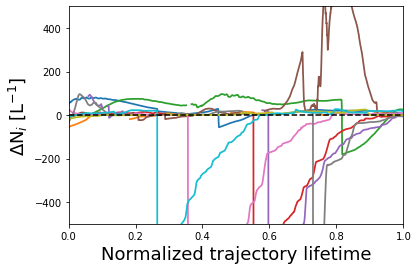

In [109]:
# Plot the differences along this 'time patch' versus a normalized time coordinate
fs = 18
fig = plt.figure()

for j in np.arange(10):
    icon_Ni = icon_traj[:,j]
    clams_Ni = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( np.array(clams_Ni) > 0 )

    # Extract the Ni values in this continuous 'time patch' for both CLaMS and ICON
    start = i[1][0]
    end = i[-1][0]

    # Calculate the qi differences along this 'time patch'
    clams_Ni = clams_Ni[start:end]
    icon_Ni = icon_Ni[start:end]
    diff = icon_Ni - clams_Ni

    # Calculate a normalized time coordinate
    t_norm = np.arange(len(diff))/len(diff)
    
    plt.plot( t_norm, diff, lw=1.75 )
    
plt.plot( [0, 1], [0, 0], color='k', ls='--', lw=1.5 )
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.ylabel( r'$\Delta$N$_i$ [L$^{-1}$]', fontsize=fs )
plt.xlim([0, 1])
plt.ylim([-500, 500])
plt.show()

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


(-500, 500)

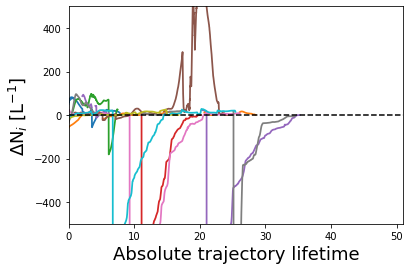

In [113]:
# Plot the differences along this 'time patch' versus an absolute time coordinate
fs = 18
fig = plt.figure()

for j in np.arange(10):
    icon_Ni = icon_traj[:,j]
    clams_Ni = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_Ni) > 0) )

    # Extract the Ni values in this continuous 'time patch' for both CLaMS and ICON
    start = i[1][0]
    end = i[-1][0]

    # Calculate the qi differences along this 'time patch'
    clams_Ni = clams_Ni[start:end]
    icon_Ni = icon_Ni[start:end]
    diff = icon_Ni - clams_Ni
    
    plt.plot( np.arange(len(diff))*24/3600., diff, lw=1.75 )
    
plt.plot( [0, 7651], [0, 0], color='k', ls='--', lw=1.5 )
plt.xlabel( 'Absolute trajectory lifetime', fontsize=fs )
plt.ylabel( r'$\Delta$N$_i$ [L$^{-1}$]', fontsize=fs )
plt.xlim([0, 51])
plt.ylim([-500, 500])

### (2) Digitize the trajectory differences along the normalized or absolute time coordinate

In [114]:
for j in np.arange(1000):
    if j%100 == 0:
        print(j)
        
    # Reinitialize this list of differences at every iteration with the bin number <m>
    diff_list = [ [] for i in np.arange(m) ]
    icon_Ni = icon_traj[:,j]
    clams_Ni = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_Ni) > 0) )

    # Extract the Ni values in this continuous 'time patch' for both CLaMS and ICON
    # only if such a patch exists
    if len(i) > 3:
        start = i[1][0]
        end = i[-1][0]
    
        # Calculate the Ni differences along this 'time patch'
        clams_Ni = clams_Ni[start:end]
        icon_Ni = icon_Ni[start:end]
        diff = icon_Ni - clams_Ni

        # Calculate a normalized time coordinate
        t_norm = np.arange(len(diff))/len(diff)
    
        # Digitize these t_norm values into tbins
        #k = np.digitize( x=t_norm, bins=tbins_norm )
        k = xr.apply_ufunc( np.digitize, t_norm, tbins_norm )
    
        for elem_idx, group_idx in enumerate(k):
            diff_list[group_idx].append( diff[elem_idx].values )
    
        for l in np.arange(m):
            if len(diff_list[l]):
                diff_vals2[j,l] = np.nanmean( diff_list[l] )
    else:
        continue

0


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900


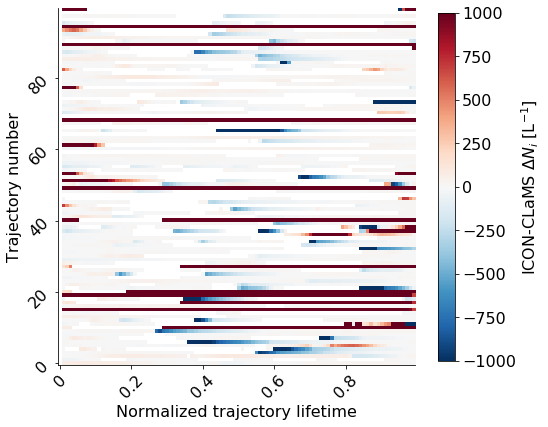

In [121]:
fs = 16
fig = plt.figure( figsize=(8,8) )
plt.imshow( diff_vals2[:100], aspect=1, origin='lower', cmap=cm.RdBu_r, vmin=-1000, vmax=1000 )
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.ylabel( 'Trajectory number', fontsize=fs )
plt.gca().set_xticks( [0, 20, 40, 60, 80] )
plt.gca().set_xticklabels( [0, 0.2, 0.4, 0.6, 0.8] )
sexy_axes( plt.gca(), fs=fs )
cb = plt.colorbar( shrink=0.8 )
cb.set_label( r'ICON-CLaMS $\Delta N_i$ [L$^{-1}$]', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

In [131]:
diff_vals3 = np.zeros((diff_vals2.shape))
diff_vals3[:] = np.nan

for j in np.arange(1000):
    if j%100 == 0:
        print(j)
        
    # Reinitialize this list of differences at every iteration with the bin number <m>
    diff_list = [ [] for i in np.arange(m) ]
    icon_Ni = icon_traj[:,j]
    clams_Ni = clams_traj[:,j]

    # Find the first and last non-zero element (continuously) along the CLaMS trajectory
    i = np.argwhere( (np.array(clams_Ni) > 0) )

    # Extract the Ni values in this continuous 'time patch' for both CLaMS and ICON
    # only if such a patch exists
    if len(i) > 3:
        start = i[1][0]
        end = i[-1][0]
    
        # Calculate the Ni differences along this 'time patch'
        clams_Ni = clams_Ni[start:end]
        icon_Ni = icon_Ni[start:end]
        diff = icon_Ni - clams_Ni
        
        # Calculate an absolute time coordinate
        t_abs = np.arange(len(diff))
    
        # Digitize these t_norm values into tbins
        #k = np.digitize( x=t_norm, bins=tbins_norm )
        k = xr.apply_ufunc( np.digitize, t_abs, tbins )
    
        for elem_idx, group_idx in enumerate(k):
            diff_list[group_idx].append( diff[elem_idx].values )
    
        for l in np.arange(m):
            if len(diff_list[l]):
                diff_vals3[j,l] = np.nanmean( diff_list[l] )
    else:
        continue

0


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900


### (3) Bin these digitized values either in normalized or absolute time into a 2D histogram

In [122]:
# Count how many trajectories hit a certain Ni difference along the normalized lifetime
Ni_diff_bins = np.linspace( -100, 100, 50 )
diff_hist2 = np.apply_along_axis( lambda a: np.histogram(a, bins=Ni_diff_bins)[0], axis=0, arr=diff_vals2 )

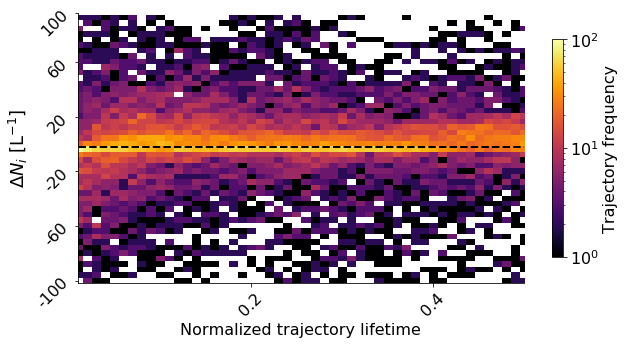

In [129]:
fs = 16
fig = plt.figure( figsize=(10,8) )
plt.imshow( diff_hist2, aspect=0.6, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=100) )
plt.xlabel( 'Normalized trajectory lifetime', fontsize=fs )
plt.plot( [0, 100], [24.5, 24.5], color='k', linestyle='--', lw=2 )

plt.ylabel( r'$\Delta N_i$ [L$^{-1}$]', fontsize=fs+2 )
plt.gca().set_yticks( [0, 10, 20, 30, 40, 49] )
plt.gca().set_yticklabels( [-100, -60, -20, 20, 60, 100] )
plt.gca().set_xticks( [0, 20, 40, 60, 80, 100] )
plt.gca().set_xticklabels( [0, 0.2, 0.4, 0.6, 0.8, 1] )
sexy_axes( plt.gca(), fs=fs )
plt.xlim([1,50])
cb = plt.colorbar( shrink=0.5 )
cb.set_label( r'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

In [132]:
diff_hist3 = np.apply_along_axis( lambda a: np.histogram(a, bins=Ni_diff_bins)[0], axis=0, arr=diff_vals3 )

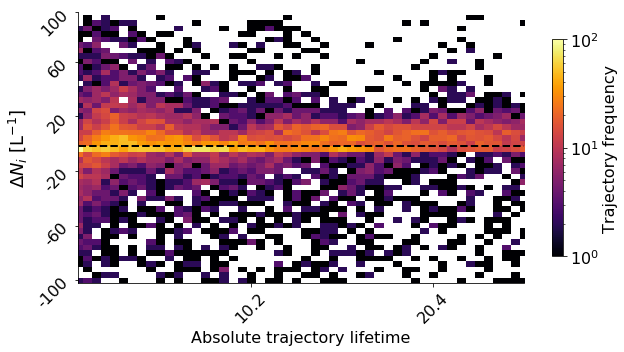

In [133]:
fs = 16
fig = plt.figure( figsize=(10,8) )
plt.imshow( diff_hist3, aspect=0.6, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=100) )
plt.xlabel( 'Absolute trajectory lifetime', fontsize=fs )
plt.plot( [0, 100], [24.5, 24.5], color='k', linestyle='--', lw=2 )

plt.ylabel( r'$\Delta N_i$ [L$^{-1}$]', fontsize=fs+2 )
plt.gca().set_yticks( [0, 10, 20, 30, 40, 49] )
plt.gca().set_yticklabels( [-100, -60, -20, 20, 60, 100] )
plt.gca().set_xticks( [0, 20, 40, 60, 80, 100] )
xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
plt.gca().set_xticklabels( xtic_vals )
sexy_axes( plt.gca(), fs=fs )
plt.xlim([1,50])
cb = plt.colorbar( shrink=0.5 )
cb.set_label( r'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )
plt.show()

## Loading the full (~30000) qi_norm / qi_abs / Ni_norm / Ni_abs values from npy files
These values are calculated over all trajectories in batch jobs (submit_diff_lifetime.sh) from diff_abs_lifetime.py or diff_norm_lifetime.py.

In [2]:
qin_1M = np.load( basedir + 'traj_pp/qi_norm_diff_vals_1M.npy' )
qin_2M = np.load( basedir + 'traj_pp/qi_norm_diff_vals_2M.npy' )
qia_1M = np.load( basedir + 'traj_pp/qi_abs_diff_vals_1M.npy' )
qia_2M = np.load( basedir + 'traj_pp/qi_abs_diff_vals_2M.npy' )

Nin_2M = np.load( basedir + 'traj_pp/Ni_norm_diff_vals_2M.npy' )
Nia_2M = np.load( basedir + 'traj_pp/Ni_abs_diff_vals_2M.npy' )

In [35]:
# Count how many trajectories hit a certain qi difference along the normalized lifetime
qi_diff_bins_1M = np.linspace( -400, 300, 50 )
qi_diff_bins_2M = np.linspace( -400, 750, 50 )
qin1M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_1M)[0], axis=0, arr=qin_1M ) #, weights=
qin2M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_2M)[0], axis=0, arr=qin_2M )
qia1M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_1M)[0], axis=0, arr=qia_1M )
qia2M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_2M)[0], axis=0, arr=qia_2M )

Ni_diff_bins_2M = np.linspace( -300, 300, 50 )
Nin2M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=Ni_diff_bins_2M)[0], axis=0, arr=Nin_2M )
Nia2M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=Ni_diff_bins_2M)[0], axis=0, arr=Nia_2M )

qi_guys = [ qin1M_diff_hist, qia1M_diff_hist, qin2M_diff_hist , qia2M_diff_hist ]
Ni_guys = [ Nin2M_diff_hist, Nia2M_diff_hist ]
xl = ['', '', 'Normalized trajectory lifetime', 'Absolute trajectory lifetime [hrs]' ]
xl2 = [ 'Normalized trajectory lifetime', 'Absolute trajectory lifetime [hrs]' ]
let = [ '(a) 1M - norm', '(b) 1M - abs', '(c) 2M - norm', '(d) 2M - abs' ]
let2 = [ '(a) 2M - norm', '(b) 2M - abs' ]

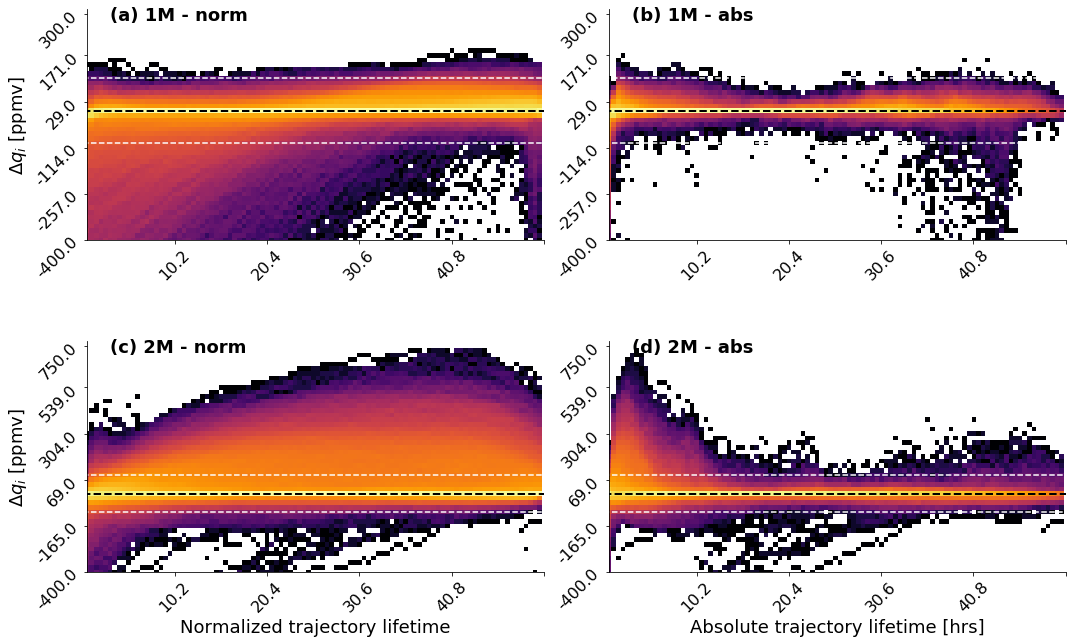

In [20]:
fs = 16
fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(15,10) )
for q, a, j in zip(qi_guys, ax.flatten(), np.arange(4)):
    a.imshow( q, aspect=1, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=10000) )
    
    a.set_yticks( [0, 10, 20, 30, 40, 49] )
    if j == 0 or j == 1:
        ytic_vals = [ round(qi_diff_bins_1M[x]) for x in [0, 10, 20, 30, 40, 49] ]
        k = np.argmin( np.abs(qi_diff_bins_1M) )
        a.plot( [0, 100], [k, k], color='k', linestyle='--', lw=2 )
        k = np.argmin( np.abs(qi_diff_bins_1M-100) )
        a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
        k = np.argmin( np.abs(qi_diff_bins_1M+100) )
        a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
    else:
        ytic_vals = [ round(qi_diff_bins_2M[x]) for x in [0, 10, 20, 30, 40, 49] ]
        k = np.argmin( np.abs(qi_diff_bins_2M) )
        a.plot( [0, 100], [k, k], color='k', linestyle='--', lw=2 )
        k = np.argmin( np.abs(qi_diff_bins_2M-100) )
        a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
        k = np.argmin( np.abs(qi_diff_bins_2M+100) )
        a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
    a.set_yticklabels( ytic_vals )
    a.set_xticks( [0, 20, 40, 60, 80, 100] )
    a.set_xlim( [1, 100] )
    a.set_ylim( [0, 50] )
    xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
    a.set_xticklabels( xtic_vals )
    sexy_axes( a, fs=fs ) 
    a.text( 0.05, 0.95, let[j], fontsize=fs+2, weight='bold', transform=a.transAxes )
    if j > 1:
        a.set_xlabel( xl[j], fontsize=fs+2 )
    if j%2 == 0:
        a.set_ylabel( r'$\Delta q_i$ [ppmv]', fontsize=fs+2 )

#cb = plt.colorbar( shrink=0.5 )
#cb.set_label( r'Trajectory frequency', fontsize=fs )
#cb.ax.tick_params( labelsize=fs )

plt.tight_layout()
#fig.savefig( '/work/bb1018/b380873/tropic_vis/output/qi-lifetime-diff.pdf', bbox_inches='tight' )
plt.show()

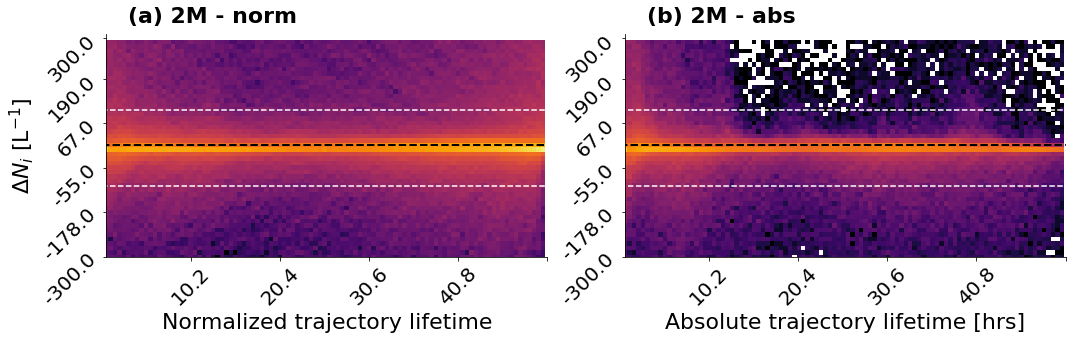

In [38]:
fs = 20
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(15,10) )
for q, a, j in zip(Ni_guys, ax.flatten(), np.arange(2)):
    h = a.imshow( q, aspect=1, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=10000) )
    
    a.set_yticks( [0, 10, 20, 30, 40, 49] )
    ytic_vals = [ round(Ni_diff_bins_2M[x]) for x in [0, 10, 20, 30, 40, 49] ]
    k = np.argmin( np.abs(Ni_diff_bins_2M) )
    a.plot( [0, 100], [k, k], color='k', linestyle='--', lw=2 )
    k = np.argmin( np.abs(Ni_diff_bins_2M-100) )
    a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
    k = np.argmin( np.abs(Ni_diff_bins_2M+100) )
    a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
    a.set_yticklabels( ytic_vals )
    a.set_xticks( [0, 20, 40, 60, 80, 100] )
    a.set_xlim( [1, 100] )
    a.set_ylim( [0, 50] )
    xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
    a.set_xticklabels( xtic_vals )
    sexy_axes( a, fs=fs ) 
    a.text( 0.05, 1.05, let2[j], fontsize=fs+2, weight='bold', transform=a.transAxes )
    a.set_xlabel( xl2[j], fontsize=fs+2 )
    if j%2 == 0:
        a.set_ylabel( r'$\Delta N_i$ [L$^{-1}$]', fontsize=fs+2 )

#cb = plt.colorbar( shrink=0.5 )
#cb.set_label( r'Trajectory frequency', fontsize=fs )
#cb.ax.tick_params( labelsize=fs )

plt.tight_layout()
fig.savefig( '/work/bb1018/b380873/tropic_vis/output/Ni-lifetime-diff.pdf', bbox_inches='tight' )
plt.show()

# Correlations of qi and Ni differences

In [2]:
#qia_2M = np.load( basedir + 'traj_pp/qi_abs_diff_vals_2M.npy' )
#Nia_2M = np.load( basedir + 'traj_pp/Ni_abs_diff_vals_2M.npy' )

trajdir = '/work/bb1018/b380873/traj_output/'
T_icon = xr.open_dataset( trajdir + 'ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc' )['T']
T_clams = xr.open_dataset( trajdir + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc' )['T']
RHi_icon = xr.open_dataset( trajdir + 'ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc')['RHI']
RHi_clams = xr.open_dataset( trajdir + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc')['RHI']

print(T_icon.shape)
#h, _, _ = plt.hist2d( qia_2M, Nia_2M, bins=[qi_diff_bins, Ni_diff_bins] )

(7651, 27738)


In [ ]:

h, _, _ = plt.hist2d( qia_2M, Nia_2M, bins=[qi_diff_bins, Ni_diff_bins] )